In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import joblib
from tqdm import tqdm

In [2]:
CHAR_SHEET_TRAIN = ['char01(B)', 'char02(D)', 'char03(G)', 'char04(L)', 'char05(O)', 'char06(Q)',
                    'char07(S)', 'char08(V)', 'char09(Z)', 'char10(4)', 'char11(7)', 'char12(9)']
CHAR_SHEET_TEST = ['char' + str(i) for i in range(13, 23)]

In [3]:
def read_single_excel(root, prefix, file_type, sheetName):
    path = os.path.join(root, prefix, prefix + file_type + '.xlsx')
    data = pd.read_excel(path, sheet_name=sheetName, header=None)
    print(f'file path: {path}, \t sheet name: {sheetName}, \t shape: {data.shape}')
    return data
def data_exists(root,variable_name):
    path = os.path.join(root, variable_name + '.pkl')
    return os.path.exists(path)
def load_data(root,variable_name):
    path = os.path.join(root, variable_name + '.pkl')
    return joblib.load(path)
def save_data(root,variable_name,variable):
    path = os.path.join(root, variable_name + '.pkl')
    return joblib.dump(variable, path)

In [221]:
# 读取数据
root = './'
train_data, test_data, test_event, train_event = [], [], [], []
if data_exists(root, 'train_data'):
    train_data=load_data(root, 'train_data')
    test_data=load_data(root, 'test_data')
    test_event=load_data(root, 'test_event')
    train_event=load_data(root, 'train_event')
else:
    for i in range(1, 6):
        prefix = 'S' + str(i)
        train_data_i, test_data_i, test_event_i, train_event_i = [], [], [], []
        for sheet_name in CHAR_SHEET_TRAIN:
            train_data_i.append(read_single_excel(root, prefix, '_train_data', sheet_name))
            train_event_i.append(read_single_excel(root, prefix, '_train_event', sheet_name))
        for sheet_name in CHAR_SHEET_TEST:
            if i == 2 and sheet_name == 'char22': # 跳过 S2 数据缺失问题
                test_data_i.append(read_single_excel(root, prefix, '_test_data', sheet_name))
                test_event_i.append(None)
                continue
            if i == 3 and sheet_name == 'char22': # 跳过 S3 数据缺失问题
                test_data_i.append(None)
                test_event_i.append(read_single_excel(root, prefix, '_test_event', sheet_name))
                continue
            test_data_i.append(read_single_excel(root, prefix, '_test_data', sheet_name))
            test_event_i.append(read_single_excel(root, prefix, '_test_event', sheet_name))
        train_data.append(train_data_i)
        test_data.append(test_data_i)
        test_event.append(test_event_i)
        train_event.append(train_event_i)
    save_data(root, 'train_data', train_data)
    save_data(root, 'test_data', test_data)
    save_data(root, 'test_event', test_event)
    save_data(root, 'train_event', train_event)
print(f'{len(train_data)}, \t {len(train_event)}, \t {len(test_data)}, \t {len(test_event)}')
print(f'{len(train_data[0])}, \t {len(train_event[0])}, \t {len(test_data[0])}, \t {len(test_event[0])}')

CHAR_TEST_NUM = [113, 106, 131, 128, 109]
for i in range(5):
    time_data, tags, row_col = [], [], []
    for j in range(5):
        train_data[i].append(test_data[i][j])
        test_event[i][j].iloc[0, 0] = CHAR_TEST_NUM[j]
        train_event[i].append(test_event[i][j])

5, 	 5, 	 5, 	 5
12, 	 12, 	 10, 	 10


In [228]:
train_event[0][13]

,0,1
0,106,250
1,4,257
2,10,303
3,9,345
4,12,391
...,...,...
61,7,2695
62,5,2737
63,12,2780
64,11,2824


In [6]:
train_data[0][0].shape

(3125, 20)

In [7]:
# 画图
time_from_to = [500,int(500+800/4)]
# 4ms一次采样，放缩fuzzy倍
fuzzy = 1
# 观察哪些通道
channels = [19]
# channels = list(range(20))

np.random.seed(17)
colors = np.random.rand(20,3,)
plt.title('Wave Analysis')
x = list(range(time_from_to[0],time_from_to[1], fuzzy))
y = train_data[0][0].iloc[time_from_to[0]:time_from_to[1],:20]
y = y.loc[x]
for i in channels:
    thisy = y.iloc[:,i]
    # thisy /= np.var(thisy)
    thisy /= np.mean(thisy)
    thisy -= np.mean(thisy)
    plt.plot(x[:28],maxpool(thisy,7,7), color=colors[i], label=str(i+1))
    # plt.plot(x,thisy, color=colors[i], label=str(i+1))
plt.legend() # 显示图例

plt.xlabel('T')
plt.ylabel('A')
plt.show()

NameError: name 'maxpool' is not defined

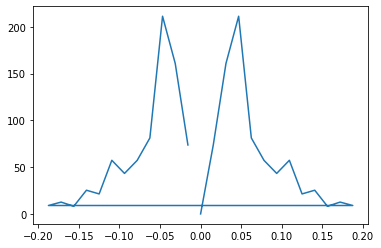

In [8]:
n = 64
sp=np.fft.fft(train_data[0][0].iloc[800:1000,0],n=n)
sp[np.abs(sp)>3000]=0
freq = np.fft.fftfreq(n)
# plt.plot(freq, sp.real, freq, sp.imag)
plt.plot(freq[np.nonzero(abs(freq)<0.2)], np.abs(sp[np.nonzero(abs(freq)<0.2)]))
plt.show()
# print(sp,freq)

In [9]:
# import sampen2
# from imp import reload
# reload(sampen2)
# sample_entropy = []

# for n in range(1):
#     sample_entropy_n = []
#     for m in tqdm(range(12)):
#         sample_entropy_m = []
#         for i in range(20):
#             sample_entropy_i = []
#             for j in range(len(train_data[n][m]) - 150):
#                 series_data = train_data[n][m].iloc[j:150+j, i]
#                 sampen_of_series = sampen2.sampen2(series_data.tolist(), 10, 2)[-1][1]
#                 sample_entropy_i.append(sampen_of_series)
#             sample_entropy_m.append(sample_entropy_i)
#         sample_entropy_n.append(sample_entropy_m)
#     sample_entropy.append(sample_entropy_n)
# print(sample_entropy)

In [336]:
# 特征工程
import pywt
from scipy import signal
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from mne.decoding import CSP
import sampen2
from imp import reload
reload(sampen2)

ica_components = 3
pca = PCA(n_components=2*ica_components)
ica = FastICA(n_components=ica_components)
csp = CSP(n_components=4, reg=None, log=True, norm_trace=True)

n = 64

'''
A	101	B	102	C	103	D	104	E	105	F	106
G	107	H	108	I	109	J	110	K	111	L	112
M	113	N	114	O	115	P	116	Q	117	R	118
S	119	T	120	U	121	V	122	W	123	X	124
Y	125	Z	126	1	127	2	128	3	129	4	130
5	131	6	132	7	133	8	134	9	135	0	136
'''
map_char_id={
    "A":101,"B":102,"C":103,"D":104,"E":105,"F":106,
    "G":107,"H":108,"I":109,"J":110,"K":111,"L":112,
    "M":113,"N":114,"O":115,"P":116,"Q":117,"R":118,
    "S":119,"T":120,"U":121,"V":122,"W":123,"X":124,
    "Y":125,"Z":126,"1":127,"2":128,"3":129,"4":130,
    "5":131,"6":132,"7":133,"8":134,"9":135,"0":136,
}
map_id_char={}
for char,id in map_char_id.items():
    map_id_char[id]=char
exists_xy_char=["","ABCDEF","GHIJKL","MNOPQR","STUVWX","YZ1234","567890","AGMSY5","BHNTZ6","CIOU17","DJPV28","EKQW39","FLRX40"]
for i,v in enumerate(exists_xy_char):
    m = set()
    for c in v:
        m.add(c)
    exists_xy_char[i]=m


def WPEnergy(data, fs, wavelet, maxlevel=6):
    iter_freqs = [
        {'name': 'Delta', 'fmin': 0.5, 'fmax': 4},
        {'name': 'Theta', 'fmin': 4, 'fmax': 8},
        {'name': 'Alpha', 'fmin': 8, 'fmax': 13},
        {'name': 'Beta', 'fmin': 13, 'fmax': 35},
    ]
    # 小波包分解
    wp = pywt.WaveletPacket(data=data, wavelet=wavelet, mode='symmetric', maxlevel=maxlevel)
    # 频谱由低到高的对应关系，这里需要注意小波变换的频带排列默认并不是顺序排列，所以这里需要使用’freq‘排序。
    freqTree = [node.path for node in wp.get_level(maxlevel, 'freq')]
    # 计算maxlevel最小频段的带宽
    freqBand = fs / (2 ** maxlevel)
    # 定义能量数组
    energy = []
    # 循环遍历计算四个频段对应的能量
    for iter in range(len(iter_freqs)):
        iterEnergy = 0.0
        for i in range(len(freqTree)):
            # 第i个频段的最小频率
            bandMin = i * freqBand
            # 第i个频段的最大频率
            bandMax = bandMin + freqBand
            # 判断第i个频段是否在要分析的范围内
            if (iter_freqs[iter]['fmin'] <= bandMin and iter_freqs[iter]['fmax'] >= bandMax):
                val = pow(np.linalg.norm(wp[freqTree[i]].data, ord=None), 2)
                if val<1000:
                    # 计算对应频段的累加和
                    iterEnergy += val
                # else:
                    # print(val)
                    # pass
        # 保存四个频段对应的能量和
        energy.append(iterEnergy)
    # 绘制能量分布图
    # plt.plot([xLabel['name'] for xLabel in iter_freqs], energy, lw=0, marker='o')
    # plt.title('能量分布')
    # plt.show()
    return energy

def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma

def maxpool(data,n,step):
    data2 = []
    for i in range(n//2,len(data)-(-n//2+n),step):
        data2.append(max(data[i-n//2:i-n//2+n]))
    return data2

def avgpool(data,n,step):
    data2 = []
    for i in range(n//2,len(data)-(-n//2+n),step):
        data2.append(np.mean(np.asarray(data[i-n//2:i-n//2+n])))
    return data2

# fc = 125
# Wn = [0.5 / fc, 30 / fc]
# b, a = signal.butter(4, Wn, 'bandpass')
# train_data2=train_data
# for i in range(len(train_data)):
#     for j in range(len(train_data[0])):
#         for k in train_data[i][j].columns.values.tolist():
#             train_data2[i][j][k] = signal.filtfilt(b, a, standardization(train_data[i][j][k]))

def get_data():
    features = []
    tags = []
    # FIXME:
    # for i_person in range(5):
    for i_person in [1]:
        for i_char_sheet in tqdm(range(17)):
            char_id=train_event[i_person][i_char_sheet].iloc[0,0]
            char=map_id_char[char_id]
            begin_time=train_event[i_person][i_char_sheet].iloc[0,1]
            data = np.array(train_data[i_person][i_char_sheet])
            data2 = np.array(train_data2[i_person][i_char_sheet])
            # print(data[0,3]==train_data[i_person][i_char_sheet].iloc[0,3])
            # data -= np.mean(data,axis=1,keepdims=True)
            # data2 = ica.fit_transform(pca.fit_transform(standardization(data)))
            
            for i_row in range(1,len(train_event[i_person][i_char_sheet]),13):
                event_group = train_event[i_person][i_char_sheet].iloc[i_row:i_row+12]
                # print(event_group,i_row)

                # # csp预处理
                # data_group_csp=[]
                # for i in range(12):
                #     d = data[int(event_group.iloc[i,1]):int(event_group.iloc[i,1])+120,:]
                #     d = [maxpool(standardization(d[:,c]),7,7) for c in range(20)]
                #     data_group_csp.append(d)
                # _tags = [char in exists_xy_char[int(event_group.iloc[i,0])] for i in range(12)]
                # data_group_csp = csp.fit_transform(np.asarray(data_group_csp),_tags)
                
                for i in range(12):
                    sp = []
                    sp1 = []
                    sp2 = []
                    sp3 = []
                    s = []
                    fourier = []
                    paras=[0,60,120]

                    # 小波变换，计算paras各个阶段的alpha、beta等能量累加比例
                    # for j in range(20):
                    #     chan = []
                    #     for p in range(len(paras)-1):
                    #         t = WPEnergy(standardization(data[int(event_group.iloc[i,1])+paras[p] : int(event_group.iloc[i,1])+paras[p+1],j]),fs=125, wavelet='db4', maxlevel=6)
                    #         chan.append(t)
                    #     chan.append(np.sum(np.asarray([normalization(c) for c in chan[:len(paras)-1]]),axis=0))
                    #     chan.append(np.sum(np.asarray(chan[:len(paras)-1]),axis=0))
                    #     chan = [normalization(c) for c in chan]
                    #     sp1.append(chan)
                    # sp1 = np.mean(np.array(sp1),axis=0)
                    # sp1 = np.concatenate(sp1)
                    
                    # 计算样本方差和均值
                    # for p in range(len(paras)-1):
                    #     sp3.append(np.mean([np.var(standardization(data[int(event_group.iloc[i,1])+paras[p] : int(event_group.iloc[i,1])+paras[p+1],j])) for j in range(20)]))
                    #     sp3.append(np.mean([np.mean(standardization(data[int(event_group.iloc[i,1])+paras[p] : int(event_group.iloc[i,1])+paras[p+1],j])) for j in range(20)]))
                    # sp3 = np.asarray(sp3)

                    # 三次小波变换波形拟合
                    for j in range(20):
                        d = standardization(data[int(event_group.iloc[i,1]): int(event_group.iloc[i,1])+120,j])
                        # 三次haar小波变换，相当于低通滤波，降噪
                        d, _ = pywt.dwt(d, 'haar')
                        d, _ = pywt.dwt(d, 'haar')
                        d, _ = pywt.dwt(d, 'haar')
                        # d = avgpool(d,3,1)
                        sp2.append(d)
                    # sp2 = np.mean(sp2,axis=0)
                    sp2 = np.concatenate(sp2)


                    # # csp过拟合
                    # sp3 = [np.mean(data_group_csp[i])]
                    # # or
                    # sp3 = data_group_csp[i]
                    
                    # 取通道做最大池化波形拟合
                    # s = np.mean([maxpool(np.asarray(standardization(data[int(event_group.iloc[i,1]): int(event_group.iloc[i,1])+120,j])),5,3) for j in [13,14,19]],axis=0)
                    s = [maxpool(np.asarray(standardization(data[int(event_group.iloc[i,1]): int(event_group.iloc[i,1])+120,j])),5,3) for j in range(20)]

                    pca = PCA(n_components=5)

                    s = pca.fit_transform([s])
                    s = np.concatenate(s)
                    # or
                    # s = np.mean([maxpool(np.asarray(data2[int(event_group.iloc[i,1]): int(event_group.iloc[i,1])+120,j]),5,3) for j in range(20)],axis=0)

                    # 傅里叶取35hz波形
                    # fourier=np.mean([np.abs(np.fft.fft(
                    #         s,n=n
                    #     )) for j in range(20)],axis=0)
                    # fourier[np.abs(fourier)>5000]=0
                    # fourier=fourier[np.nonzero(abs(freq)<0.2)]

                    sp = np.concatenate([sp, fourier, sp1, sp2, sp3, s])
                    features.append(sp)
                    tags.append(int(char in exists_xy_char[int(event_group.iloc[i,0])]))
                # return
    return np.asarray(features),np.asarray(tags)
features, tags = get_data()
# res = WPEnergy2(train_data[0][0].iloc[100:200,0],fs=125, wavelet='db4', maxlevel=8)
# train_data,res
# np.asarray(pywt.dwt(train_data[0][0].iloc[100:200,0], 'haar')).shape
features.shape


100%|██████████| 17/17 [00:04<00:00,  3.52it/s]


(1020, 1080)

In [317]:
# tags
features.shape

(1020, 1080)

In [337]:
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
ica = FastICA(n_components=30)
pca = PCA(n_components=30)

features = pca.fit_transform(features)
# features = ica.fit_transform(features)
features.shape

(1020, 60)

In [338]:
# 模型调优

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import xgboost as xgb

num_test=5

x_train,x_test,y_train,y_test = train_test_split(features,        # 特征空间
                                                    tags,      # 输出空间
                                                    test_size = num_test/17,    # 测试集占k/12个sheet
                                                    random_state = 33,  # 为了复现实验，设置一个随机数
                                                    shuffle=False
                                                    )
def crit(model,X,y):
    y_pred=model.predict(X)
    tp=np.sum(y[np.nonzero(y_pred==1)]==1)
    fp=np.sum(y[np.nonzero(y_pred==1)]==0)
    fn=np.sum(y[np.nonzero(y_pred==0)]==1)
    tn=np.sum(y[np.nonzero(y_pred==0)]==0)
    return tp/(tp+fp+fn)

def xgboost_cv(data,targets,max_depth,learning_rate,n_estimators,min_child_weight,max_delta_step,subsample,colsample_bytree,reg_alpha,reg_lambda):
    """SVC cross validation.
    This function will instantiate a SVC classifier with parameters C and
    gamma. Combined with data and targets this will in turn be used to perform
    cross validation. The result of cross validation is returned.
    Our goal is to find combinations of C and gamma that maximizes the roc_auc
    metric.
    """
    estimator = XGBClassifier(
        max_depth=max_depth, 
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        min_child_weight=min_child_weight,
        max_delta_step=max_delta_step,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        nthread=5,
        # eval_metric='error@'+str(errorat),
        # eval_metric='auc',
        # eval_metric=evalmcc_min,
        # eval_metric=["rmse","logloss"],
        scale_pos_weight=6,
        objective='binary:logistic'
    )
    cval = cross_val_score(estimator, data, targets, scoring='recall', cv=5)
    # cval = cross_val_score(estimator, data, targets, scoring=crit, cv=5)
    # cval = cross_val_score(estimator, data, targets, scoring='roc_auc', cv=5)
    return cval.mean()

def optimize_xgboost(data, targets, n_iter=10):
    """Apply Bayesian Optimization to SVC parameters."""

    def xgboost_crossval(max_depth,learning_rate,n_estimators,min_child_weight,max_delta_step,subsample,colsample_bytree,reg_alpha,reg_lambda):
        return xgboost_cv(data, targets,int(max_depth),learning_rate,int(n_estimators),min_child_weight,max_delta_step,subsample,colsample_bytree,reg_alpha,reg_lambda)

    optimizer = BayesianOptimization(
        f=xgboost_crossval,
        pbounds={
            'max_depth': [3, 25],
            'learning_rate': [0.01, 0.15],
            'n_estimators': [10, 80],
            'min_child_weight': [15, 25],
            'max_delta_step': [2, 5],
            'subsample': [0.7, 0.95],
            'colsample_bytree': [0.5, 0.9],
            'reg_alpha': [0.5, 1],
            'reg_lambda': [0.5, 1]
        },
        random_state=3333,
        verbose=2
    )
    optimizer.maximize(n_iter=n_iter)

    print("Final result:", optimizer.max)

%time optimize_xgboost(x_train,y_train,45)


|   iter    |  target   | colsam... | learni... | max_de... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.5333   |  0.8006   |  0.0253   |  3.458    |  14.0     |  21.57    |  26.51    |  0.8064   |  0.5598   |  0.8781   |
|  2        |  0.45     |  0.649    |  0.08347  |  2.79     |  16.68    |  19.49    |  25.33    |  0.9241   |  0.9704   |  0.9484   |
|  3        |  0.4583   |  0.5614   |  0.09532  |  2.872    |  9.401    |  23.18    |  52.68    |  0.8056   |  0.9307   |  0.7928   |
|  4        |  0.4583   |  0.5775   |  0.07489  |  2.662    |  5.645    |  21.67    |  60.86    |  0.7294   |  0.6837   |  0.7749   |
|  5        |  0.35     |  0.6024   |  0.1109   |  2.059    |  20.33    |  15.63    |  24.33    |  0.7385   |  0.5629   |  0.837    |
|  6        |  0.5083   |  0.8567   |  0.07749  |  4.778    | 

In [62]:
# 检验数据是否没有被打乱
np.sum((features[:len(x_train)]==x_train)==True)==x_train.shape[0]*x_train.shape[1]

True

In [326]:
# 模型训练与测试
from xgboost import XGBClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

def train_xgboost(params):
    model = XGBClassifier(
        colsample_bytree=params['colsample_bytree'],
        learning_rate=params['learning_rate'],
        max_delta_step=params['max_delta_step'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],
        n_estimators=int(params['n_estimators']),
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        subsample=params['subsample'],
        # eval_metric=["rmse","logloss"],
        scale_pos_weight=6,
        objective='binary:logistic',
    )
    model.fit(x_train,y_train)
    return model    

def train_xgboost2(params):
    model = XGBClassifier(
        colsample_bytree=params['colsample_bytree'],
        learning_rate=params['learning_rate'],
        max_delta_step=params['max_delta_step'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],
        n_estimators=int(params['n_estimators']),
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        subsample=params['subsample'],
        # eval_metric=["rmse","logloss"],
        scale_pos_weight=6,
        objective='binary:logistic',
    )
    model.fit(x_train,y_train)
    return model    

def model_test(x_test,y_test,num_test):
    y_pred = model.predict(x_test)

    # for j in range(num_test):
    #     print("目标")
    #     print(y_test[j*12*5:j*12*5+12*5])
    #     print("预测")
    #     print(y_pred[j*12*5:j*12*5+12*5])

    for sheet_base in range(0,len(y_pred),12*5):
        val = np.zeros((13,))
        val[0] = 0

        n = 5
        for batch_base in range(sheet_base,sheet_base+12*n,12):
            i_sheet = (17-num_test)+sheet_base//(12*5)
            i_event = (batch_base - sheet_base)//12
            i_event_row = 1+i_event*13
            y_pred_ = y_pred[batch_base:batch_base+12]
            y_test_ = y_test[batch_base:batch_base+12]
            y_ = train_event[1][i_sheet][i_event_row:i_event_row+12]
            res = y_pred_*np.asarray(y_.iloc[:,0])
            # print(y_)
            # print(y_pred_,np.asarray(y_.iloc[:,0]),res[res>0])
            # return
            for _, v in enumerate(res[res>0]):
                # print(v)
                val[v] += 1
        r=np.argsort(-val[1:7])[0]+1
        c=np.argsort(-val[7:])[0]+7
        # print("final",c)
        s = set()
        for _,v in enumerate(exists_xy_char[r]):
            s.add(v)
        for _,v in enumerate(exists_xy_char[c]):
            if v in s:
                print('预测',v)
                break
            
def model_test2(x_test,y_test,num_test):
    y_pred_proba = model.predict_proba(x_test)

    n = 5
    for sheet_base in range(0,len(y_pred_proba),12*5):
        val = np.zeros((13,))
        for batch_base in range(sheet_base,sheet_base+12*n,12):
            i_sheet = (17-num_test)+sheet_base//(12*5)
            i_event = (batch_base - sheet_base)//12
            i_event_row = 1+i_event*13
            y_pred_proba_ = y_pred_proba[batch_base:batch_base+12]
            y_test_ = y_test[batch_base:batch_base+12]
            y_ = train_event[1][i_sheet][i_event_row:i_event_row+12]
            for i,v in enumerate(y_.iloc[:,0]):
                val[v]+=y_pred_proba_[i][1]
        r=np.argsort(-val[1:7])[0]+1
        c=np.argsort(-val[7:])[0]+7
        # print("final",c)
        s = set()
        for _,v in enumerate(exists_xy_char[r]):
            s.add(v)
        for _,v in enumerate(exists_xy_char[c]):
            if v in s:
                print('预测',v)
                break


# %time model = train_svm({'expC': 2.323420033309046, 'expGamma': 1.570225873685972})
# %time model = train_xgboost({'colsample_bytree': 0.6777296845518767, 'errorat': 0.4145593781640215, 'learning_rate': 0.02410815068218079, 'max_delta_step': 0.025245950057545707, 'max_depth': 6.086558645510136, 'min_child_weight': 19.58672950443147, 'n_estimators': 232.7855648541887, 'reg_alpha': 0.6165691427262426, 'reg_lambda': 0.8524583027711861, 'subsample': 0.8684270346032827})
# %time model = train_xgboost({'colsample_bytree': 0.9, 'errorat': 0.2, 'learning_rate': 0.005, 'max_delta_step': 2.0, 'max_depth': 2.0, 'min_child_weight': 20.0, 'n_estimators': 60.73754308716246, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.95})
%time model = train_xgboost({'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_delta_step': 5.0, 'max_depth': 3.0, 'min_child_weight': 25.0, 'n_estimators': 72.39590517372292, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.7})

y_pred = model.predict(x_test)
# 准确率
precision = accuracy_score(y_test, y_pred)
# 召回率
recall = recall_score(y_test, y_pred)

model_test(x_train,y_train,17)
print('-----')
model_test2(x_train,y_train,17)
print('-----')
model_test(x_test,y_test,num_test)
print('-----')
model_test2(x_test,y_test,num_test)

precision, recall

CPU times: user 128 ms, sys: 2.01 ms, total: 130 ms
Wall time: 32 ms
预测 A
预测 D
预测 G
预测 F
预测 I
预测 Q
预测 S
预测 V
预测 Z
预测 Z
预测 7
预测 9
-----
预测 B
预测 D
预测 G
预测 L
预测 O
预测 Q
预测 S
预测 V
预测 Z
预测 4
预测 7
预测 9
-----
预测 A
预测 E
预测 Y
预测 P
预测 I
-----
预测 5
预测 E
预测 Y
预测 P
预测 J


(0.5766666666666667, 0.64)